# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## План реализации проекта

1. [Подготовка данных. Импорт библиотек](#step_1)
- [1.1 Грубая предобработка данных](#step_1.1)
- [1.2 Предобработка данных для задач машинного обучения](#step_1.2)
2. [Исследование задачи](#step_2)
- [2.1 Определение выборок](#step_2.1)
- [2.2 Обучение модели](#step_2.2)
- [2.3 Проверка адекватности модели](#step_2.3)
- [2.4 Подбор оптимального порога](#step_2.4)
3. [Борьба с дисбалансом классов](#step_3)
- [3.1 Метод upsampling](#step_3.1)
- [3.2 Поиск наилучшей модели на обучении upsampled выборки](#step_3.2)
- [3.3 Метод downsampling](#step_3.3)
- [3.4 Поиск наилучшей модели на обучении downsampled выборки](#step_3.4)
4. [Тестирование модели](#step_4)
5. [Общий вывод](#step_5)

## Описание данных

**Признаки**
- *RowNumber* — индекс строки в данных
- *CustomerId* — уникальный идентификатор клиента
- *Surname* — фамилия
- *CreditScore* — кредитный рейтинг
- *Geography* — страна проживания
- *Gender* — пол
- *Age* — возраст
- *Tenure* — количество недвижимости у клиента
- *Balance* — баланс на счёте
- *NumOfProducts* — количество продуктов банка, используемых клиентом
- *HasCrCard* — наличие кредитной карты
- *IsActiveMember* — активность клиента
- *EstimatedSalary* — предполагаемая зарплата

**Целевой признак**
- *Exited* — факт ухода клиента

## 1. Подготовка данных<a id='step_1'></a>

Импортируем необходимые библиотеки:

In [999]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

from sklearn.metrics import accuracy_score, f1_score, roc_curve, roc_auc_score
from sklearn.utils import shuffle

import matplotlib.pyplot as plt
import seaborn as sns

Откроем файл с данными и исследуем его:

In [929]:
df = pd.read_csv('Churn.csv')

In [930]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [931]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [932]:
df.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


Чтобы ничего не упустить, составим предварительный план предобработки данных:

### 1.1 Грубая предобработка данных<a id='step_1.1'></a>

#### План грубой предобработки данных

1. Привести названия столбцов к нижнему регистру
1. *RowNumber* - убрать
1. *Tenure* - заполнить/удалить пропуски


#### 1. Приведем названия столбцов к нижнему регистру

In [933]:
df.columns = [str.lower(i) for i in df.columns]

#### 2. Удалим столбец *RowNumber*

In [934]:
df = df.drop('rownumber', axis=1)

In [935]:
df.head(3)

,customerid,surname,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
0,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1


#### 3. Разберемся с пропусками в столбце *Tenure*

Восстановить данные с достаточной для прадоподобия точностью у нас нет возможности. Заполнять пропуски какой-либо из статистик нецелесообразно т.к. такие объекты могут в худшую сторону повлиять на качество обучения модели. Поэтому, просто отбросим объекты с пропусками.

In [936]:
df = df.dropna()

In [937]:
df.shape

(9091, 13)

###  Промежуточный вывод:

Данные очищены от лишних столбцов. Удалены пропуски. Датафрейм готов к более тонкой подготовке данных для машинного обучения.

### 1.2 Предобработка данных для задач машинного обучения<a id='step_1.2'></a>

Как мы знаем, чтобы модель лучше поняла закономерности в данных, эти самые данные должны быть определенным образом подготовлены для алгоритма обучения. Имея такую цель, определим план предобработки данных:

**Вспомним, какие есть типы признаков, и какими методами они обрабатываются:**

- Количественный признак ---> Нормирование
- Категориальный признак ---> Кодирование. Метод OHE
- Ранговый (порядковый) признак ---> Нормирование

#### План тонкой предобработки данных

1. Столбец *customerid* нам не нужен. Он внесет лишний шум в данные. Отбрасываем
1. Столбец *surname* - аналогично.
1. Признак *creditscore* - представляет собой набор числовых признаков. Для нашей задачи он может оказаться важен. Нужно его только нормировать.
1. Признак *geography* категориальный признак. Тоже представляет ценность. Но его нужно закодировать методом OHE.
1. Признак *gender* - категориальный бинарный признак. Аналогично п.4
1. Признак *age* - количественный признак. Нормировать.
1. Признак *tenure* - ранговый признак. Нормировать
1. Признак *balance* - количественный признак. Нормировать
1. Признак *numofproducts* - ранговый признак. Нормировать
1. Признак *hascrcard* - категориальный бинарный признак. В данном случае, он уже подготовлен. Оставляем без изменений
1. Признак *isactivemember* - категориальный бинарный признак. В данном случае, он уже подготовлен. Оставляем без изменений
1. Признак *estimatedsalary* - количественный признак. Нормировать
1. Проверка на **мультиколлинеарность**

#### 1. Отбросим лишние столбцы  п.1 - п.2

Будем собирать все признаки в отдельный датафрейм

In [938]:
df_ml = df.drop(['customerid', 'surname'], axis=1)

In [939]:
df_ml.head(3)

,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1


#### 2. Категориальные признаки. Обработаем сразу все**

In [940]:
df_ml = pd.get_dummies(df_ml, drop_first=True)

In [941]:
df_ml.head(3)

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited,geography_Germany,geography_Spain,gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0


И снова преобразуем столбцы к нижнему регистру:

In [942]:
df_ml.columns = [str.lower(i) for i in df_ml.columns]

In [943]:
df_ml.head(3)

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited,geography_germany,geography_spain,gender_male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0


Проверим, что ничего на пути не растеряли:

In [944]:
df_ml.shape

(9091, 12)

#### 3. Количественные признаки. Нормирование

Отделим целевой признак от остальных:

In [945]:
target = df_ml['exited']
features = df_ml.drop('exited', axis=1)

In [946]:
target.shape

(9091,)

In [947]:
features.shape

(9091, 11)

**Нормирование**

Теперь выпишем названия столбцов с числовыми признаками, которые будем нормировать:

In [948]:
numeric = ['creditscore', 'age', 'tenure', 'balance', 'numofproducts', 'estimatedsalary']

Вызовем модель для нормирования данных, и обучим ее:

In [949]:
scaler = StandardScaler()
scaler.fit(features[numeric])

StandardScaler()

Заменим числовые значения признаков на нормированные:

In [950]:
features[numeric] = scaler.transform(features[numeric])

In [951]:
features.head(3)

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,geography_germany,geography_spain,gender_male
0,-0.329200,0.289040,-1.035627,-1.227780,-0.912601,1,1,0.020264,0,0,0
1,-0.443301,0.194298,-1.381103,0.116887,-0.912601,0,1,0.214527,0,1,0
2,-1.542828,0.289040,1.037224,1.333920,2.529911,1,0,0.238632,0,0,0


Проверим размерность таблицы

In [952]:
features.shape

(9091, 11)

#### 4. Проверка на мультиколлинеарность

Построим матрицу корреляции признаков:

In [953]:
features.corr()

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,geography_germany,geography_spain,gender_male
creditscore,1.000000,-0.004504,-0.000062,0.002804,0.011090,-0.003937,0.030947,0.005182,0.000428,0.001725,-0.008547
age,-0.004504,1.000000,-0.013134,0.031481,-0.031877,-0.014129,0.082269,-0.007037,0.049038,-0.005622,-0.025631
tenure,-0.000062,-0.013134,1.000000,-0.007911,0.011979,0.027232,-0.032178,0.010520,-0.003299,0.000810,0.012634
balance,0.002804,0.031481,-0.007911,1.000000,-0.301858,-0.019055,-0.003285,0.014351,0.401701,-0.136986,0.018030
numofproducts,0.011090,-0.031877,0.011979,-0.301858,1.000000,0.005805,0.009084,0.013990,-0.009476,0.011903,-0.025176
hascrcard,-0.003937,-0.014129,0.027232,-0.019055,0.005805,1.000000,-0.008810,-0.006136,0.009149,-0.017779,0.006016
isactivemember,0.030947,0.082269,-0.032178,-0.003285,0.009084,-0.008810,1.000000,-0.020049,-0.016821,0.014800,0.025019
estimatedsalary,0.005182,-0.007037,0.010520,0.014351,0.013990,-0.006136,-0.020049,1.000000,0.011551,-0.010998,-0.002658
geography_germany,0.000428,0.049038,-0.003299,0.401701,-0.009476,0.009149,-0.016821,0.011551,1.000000,-0.332879,-0.023701
geography_spain,0.001725,-0.005622,0.000810,-0.136986,0.011903,-0.017779,0.014800,-0.010998,-0.332879,1.000000,0.015388


Сильной корреляции между признаками не выявлено, значит можно считать их независимыми. 

### Вывод

Признаки подготовлены для передачи в модель обучения. Примерно 10% данных пришлось пожертвовать из-за наличия у них пропусков. 

Проведена проверка на мультиколлинеарность. Все признаки являются независимыми. 

Числовые фичи отмасштабированы.

## 2. Исследование задачи<a id='step_2'></a>

Посмотрим на величину дисбаланса классов:

In [954]:
target.value_counts()

0    7237
1    1854
Name: exited, dtype: int64

Число текущих клиентов банка почти в 4 раза больше числа тех, кто от услуг банка отказался

Попробуем обучить модель без учета дисбаланса. В качестве самой модели возьмем **RandomForestClassifier**

### 2.1 Определение выборок<a id='step_2.1'></a>

Для начала, разобьем данные да валидационную и тренировочную выборки:

In [955]:
features_train, features_valid, target_train, target_valid = train_test_split(features, target,
                                                                             test_size=0.25,
                                                                             random_state=42)

Проверим размеры выборок:

In [956]:
for i in [features_train, features_valid, target_train, target_valid]:
    print(i.shape)

(6818, 11)
(2273, 11)
(6818,)
(2273,)


### 2.2 Обучение модели<a id='step_2.2'></a>

Создадим модель случайного леса:

In [957]:
model = RandomForestClassifier()

Перебирать лучшие параметры модели вручную не станем. С этим лучше и быстрее справится **RandomizedSearchCV**

Определим параметры, которые будет подбирать модель. Ограничимся глубиной дерева, количеством деревьев, минимальным количеством объектов в узле, и минимальным количеством объектов в листе.

In [958]:
params = {'max_depth':range(1,20,2),
          'n_estimators':range(1,100,5),
          'min_samples_split':range(2,20,2),
          'min_samples_leaf':range(1,20,2)}

In [959]:
clf = RandomizedSearchCV(model, params, random_state=42)

In [960]:
%%time
clf.fit(features_train, target_train)

CPU times: user 10.4 s, sys: 210 ms, total: 10.6 s
Wall time: 12.5 s


RandomizedSearchCV(estimator=RandomForestClassifier(),
                   param_distributions={'max_depth': range(1, 20, 2),
                                        'min_samples_leaf': range(1, 20, 2),
                                        'min_samples_split': range(2, 20, 2),
                                        'n_estimators': range(1, 100, 5)},
                   random_state=42)

Посмотрим подобранные параметры:

In [961]:
clf.best_params_

{'n_estimators': 51,
 'min_samples_split': 12,
 'min_samples_leaf': 7,
 'max_depth': 19}

In [962]:
best_model = clf.best_estimator_

In [963]:
best_model.score(features_valid, target_valid)

0.8578970523537176

### 2.3 Проверка адекватности модели<a id='step_2.3'></a>

Создадим лжемодель. Пусть предсказывает всем объектам 0. Оценим accuracy такой модели.

In [964]:
all_zeros = pd.Series(data=0, index=target_valid.index)

Оценим accuracy:

In [965]:
accuracy_score(target_valid, all_zeros)

0.7985041794984602

Чтож, наша обученная модель действительно справляется с задачей классификации лучше, чем случайная модель. Но, как мы знаем, accuracy - не лучшая метрика для сравнения. Дополнительно, оценим модели с помощью ROC - кривой.

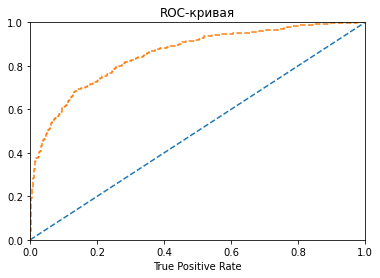

Площад под ROC-кривой обученной модели = 0.8531307517413114
Площад под ROC-кривой случайной модели = 0.5


In [966]:
probabilities_valid_rf = best_model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid_rf[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

fpr_1, tpr_1, thresholds_1 = roc_curve(target_valid, all_zeros)

plt.figure()

plt.plot(fpr_1, tpr_1, linestyle='--')
plt.plot(fpr, tpr, linestyle='--')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("False Positive Rate")
plt.xlabel("True Positive Rate")
plt.title("ROC-кривая")
plt.show()

print('Площад под ROC-кривой обученной модели =', roc_auc_score(target_valid, probabilities_one_valid))
print('Площад под ROC-кривой случайной модели =', roc_auc_score(target_valid, all_zeros))

Подводя промежуточный итог, посчитаем значение F-меры для нашей модели:

In [967]:
predicted = best_model.predict(features_valid)
print('F-мера обученной без учета дисбаланса классов модели =', f1_score(target_valid, predicted))

F-мера обученной без учета дисбаланса классов модели = 0.5431400282885431


### 2.4 Подбор оптимального порога<a id='step_2.4'></a>

Так как главная метрика проекта это F-мера, то ее и будем стараться максимизировать:

Создадим функцию подбора оптимального порога. Пусть результатом ее работы будет датафрейм с оценкой f-меры для каждого значения порога.

In [968]:
#Версия 1.02
def find_best_threshold(probabilities_valid, x_valid, y_valid, clf_name):
    
    data=pd.DataFrame({'clf':[], 'threshold':[], 'f1_score':[], 'roc_auc_score':[]})

    for threshold in np.arange(0.05, 1, 0.05):
        threshold_proba = np.where(probabilities_valid[:, 1] > threshold, 1, 0)
        score = f1_score(y_valid, threshold_proba)
        score_auc = roc_auc_score(y_valid, threshold_proba)
        data = data.append({'clf':clf_name, 
                            'threshold':threshold, 
                            'f1_score':score, 
                            'roc_auc_score':score_auc}, ignore_index=True)
    return data

Запишем результат работы функции в отдельный датафрейм:

In [969]:
disb_data_rf = find_best_threshold(probabilities_valid_rf, features_valid, target_valid, 'RFClassifier')

Не заглядывая внутрь, построим график измененния f-меры в зависимости от порога. И выведем максимальное значение, которое удалось найти:

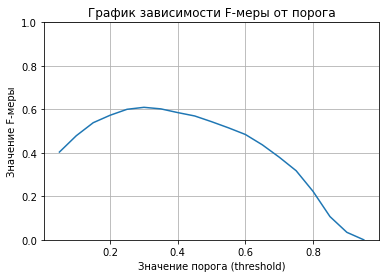

Наибольшее значение F-меры = 0.6092436974789917 при величине порога = 0.3


In [970]:
plt.plot(disb_data_rf.threshold, disb_data_rf.f1_score)
plt.ylabel('Значение F-меры')
plt.xlabel('Значение порога (threshold)')
plt.title('График зависимости F-меры от порога')
plt.grid(True)
plt.ylim([0,1]) 
plt.show()
        
print('Наибольшее значение F-меры =', disb_data_rf.query('f1_score == f1_score.max()')['f1_score'].values[0],
      'при величине порога =', disb_data_rf.query('f1_score == f1_score.max()')['threshold'].values[0])

### Вывод:

Наибольшее значение **F-меры** обученной без учета дисбаланса классов модели, которого удалось достичь = **0.6**

При наличии дисбаланса классов, такие метрики как **accuracy** практически не несут никакой информативности. Поэтому, в таком случае, нагляднее будет метрика **ROC AUC score**, которая вычисляет долю ошибок и правильных ответов. Она слабо зависит от дисбаланса.

Согласно некоторым популярным статьям таким как [эта](https://habr.com/ru/post/349078/) или вот [эта](https://qastack.ru/stats/247871/what-is-the-root-cause-of-the-class-imbalance-problem), получается, что проблема дисбаланса классов до сих пор актуальна и обсуждается. Вероятно, "не так страшен черт, как его малюют", и дисбаланс далеко не всегда сильно влияет на качество модели. Да, в задачах мультиклассификации, дисбаланс играет далеко не последнюю роль. Но, в задачах бинарной классификиации, с использованием моделей RandomForestClassifier, разный вес классов может не нести весомого вклада в качество модели.

Примем последнее утверждение в качетсве гипотезы, которую и проверим в следующем шаге.

# 3. Борьба с дисбалансом<a id='step_3'></a>

Рассмотрим 2 поднятых в обучающем курсе метода: **upsampling** и **downsampling**.

#### План борьбы с дисбалансом:

1. Увеличить вес положительного класса. Воспользоваться методом **upsampling**:
- Разделить обучающую выборку на отрицательные и положительные объекты;
- Скопировать несколько раз положительные объекты;
- С учётом полученных данных создать новую обучающую выборку;
- Перемешать данные;
2. Протестировать новую выборку на нескольких моделях. Отобрать модель с наибольшим значением F-меры

3. Уменьшить вес отрицательного класса. Воспользоваться методом **downsampling**
- Разделить обучающую выборку на отрицательные и положительные объекты;
- Случайным образом отбросить часть из отрицательных объектов;
- С учётом полученных данных создать новую обучающую выборку;
- Перемешать данные;
4. Аналогично п.2

### 3.1 Метод upsampling<a id='step_3.1'></a>

Разделим выборку на отрицательные и положительные объекты, увеличим выборку положительных, перемешаем. Для этого напишем соответствующую функцию:

In [971]:
def sampling(features, target, how=['up', 'down']):
    features_zeros = features[target_train == 0]
    features_ones = features[target_train == 1]
    target_zeros = target[target_train == 0]
    target_ones = target[target_train == 1]
    
    repeat = int(np.ceil(features_zeros.shape[0] / features_ones.shape[0]))
    
    if how == 'up':
    
        features_sampled = pd.concat([features_zeros] + [features_ones] * repeat)
        target_sampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    # могут возникать ошибки из-за особенностей округления. В этом случае примени более грубое округледние к fraction. Либо try / except    
    if how == 'down':
        fraction = 1 / repeat
        
        features_sampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
        
        target_sampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_sampled, target_sampled = shuffle(features_sampled, target_sampled, random_state=42)
    
    return features_sampled, target_sampled


Уравняем классы:

In [972]:
features_upsampled, target_upsampled = sampling(features_train, target_train, how='up')

Проверим размеры выборок:

In [973]:
print(features_upsampled.shape)
print(target_upsampled.shape)

(11006, 11)
(11006,)


### 3.2 Поиск наилучшей модели на обучении upsampled выборки<a id='step_3.2'></a>

Определим основные алгоритмы классификации, которые будем обучать:

- RandomForestClassifier
- KNeighborsClassifier
- LogisticRegression

В целях оптимизации процесса, заведем функцию, которая на вход будет получать тренировочные выборки, обучать несколько моделей, подбирать для каждой порог с максимальным значением F-меры, а на выходе отдавать словарь с наилучшими параметрами, и датафрейм со значениями F-меры:

In [974]:
#Версия 1.03
def fit_models(x_train, y_train, x_valid, y_valid, model_params):
    # Запишем все модели для обучения
    models = [RandomForestClassifier, KNeighborsClassifier, LogisticRegression]
    
    # Здесь строковые имена моделей для записи в таблицу (небольшой костыль, т.к. имена из спика выше в строку не переводятся:()
    mod_names = {0:'RandomForestClassifier', 1:'KNeighborsClassifier', 2:'LogisticRegression'}
   
    # Создадим пустой датафрейм, куда будем сохранять результаты обучения моделей
    f1_data = pd.DataFrame({'clf':[], 'threshold':[], 'f1_score':[], 'roc_auc_score':[]})
    # Создадим пустой словарь, куда будем сохранять лучшие параметры моделей
    best_model_params = {'RandomForestClassifier':{}, 'KNeighborsClassifier':{}, 'LogisticRegression':{}}
    
    
    for i in range(len(models)):
        # определяем модель
        if models[i] == KNeighborsClassifier:
            model_type = models[i]()
        else:
            model_type = models[i](random_state=42)
        clf = RandomizedSearchCV(model_type, model_params[i], random_state=42, scoring='f1')
        # Запускаем алгоритм подбора параметров 
        clf.fit(x_train, y_train)
        # Определяем модель с наилучшими параметрами
        best_model = clf.best_estimator_
        # Сохраняем в словаре лучшие параметры
        best_model_params[mod_names[i]] = clf.best_params_
        
        # Находим массив вероятностей
        probabilities_valid = best_model.predict_proba(x_valid)
        
        # Запускаем алгоритм подбора оптимального порога для лучшей модели
        f1_data = f1_data.append(find_best_threshold(probabilities_valid, x_valid, y_valid, mod_names[i]), ignore_index=True) 
    
    f1_data['average'] = (f1_data['f1_score'] + f1_data['roc_auc_score'])/2
    # На выходе получаем словарь параметров, и датафрейм с перебором порогов и значениями f-меры
    return best_model_params, f1_data

Определим массивы параметров для каждой модели (параметры для RandomForest уже лежат в переменной params)

In [975]:
params_knn = {'n_neighbors':range(3,9,1), 
              'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'],
              'leaf_size':range(5,50,5)}

params_lr = {'penalty':['none', 'l2'], 
             'class_weight':['balanced', 'None'],
             'max_iter': range(50, 150, 10)}

Сохраним все параметры списком, чтобы передать в функцию fit_models()

In [976]:
params_lst = [params, params_knn, params_lr]

Все готово для обучения. Запустим написанную выше функцию, и найдем модели с наибольшим значением f-меры:

In [977]:
best_model_params, f1_data = fit_models(features_upsampled, target_upsampled, features_valid, target_valid, params_lst)

Посмотрим на оптимальные параметры каждой модели:

In [978]:
best_model_params

{'RandomForestClassifier': {'n_estimators': 16,
  'min_samples_split': 4,
  'min_samples_leaf': 1,
  'max_depth': 17},
 'KNeighborsClassifier': {'n_neighbors': 3,
  'leaf_size': 30,
  'algorithm': 'kd_tree'},
 'LogisticRegression': {'penalty': 'none',
  'max_iter': 80,
  'class_weight': 'None'}}

Посмотрим на получившуюся таблицу:

In [979]:
f1_data.head()

,clf,threshold,f1_score,roc_auc_score,average
0,RandomForestClassifier,0.05,0.393939,0.612285,0.503112
1,RandomForestClassifier,0.10,0.438313,0.672555,0.555434
2,RandomForestClassifier,0.15,0.473310,0.707215,0.590262
3,RandomForestClassifier,0.20,0.507703,0.733039,0.620371
4,RandomForestClassifier,0.25,0.536622,0.748395,0.642509


Для наглядности, строим график зависимости f-меры и ROC AUC от порога. Т.к. планируется строить такой график не один раз, обернем его вызов в функцию:

In [997]:
def plot_f1_thresh(data):   
    for model_name in data.clf.unique():
        print(model_name)
        sns.lineplot(data=data.loc[data['clf'] == model_name], x="threshold", y="f1_score")
        sns.lineplot(data=data.loc[data['clf'] == model_name], x="threshold", y="roc_auc_score")
        sns.lineplot(data=data.loc[data['clf'] == model_name], x="threshold", y="average")
        plt.grid(True)
        plt.ylabel('Значение F-меры, ROC AUC')
        plt.xlabel('Значение порога (threshold)')
        plt.title('График зависимости значений F-меры и ROC AUC от порога')
        plt.ylim([0,1]) 
        plt.legend([data.columns[i] for i in range(2, len(data.columns))])
        plt.show()
        
        print('- Наибольшее значение F-меры = {:.3f} при величине порога = {:.2f}'.format(
              data.query('clf == @model_name')\
              .query('f1_score == f1_score.max()')['f1_score'].values[0],
              data.query('clf == @model_name')\
              .query('f1_score == f1_score.max()')['threshold'].values[0]))


        print('- Наибольшее значение ROC AUC = {:.3f} при величине порога = {:.2f}'.format(
              data.query('clf == @model_name')\
              .query('roc_auc_score == roc_auc_score.max()')['roc_auc_score'].values[0],
              data.query('clf == @model_name')\
              .query('roc_auc_score == roc_auc_score.max()')['threshold'].values[0]))

        print('- Наибольшее взаимное значение ROC AUC = {:.3f} и F-меры = {:.3f} достигается при величине порога = {:.2f}'.format(
              data.query('clf == @model_name')\
              .query('average == average.max()')['roc_auc_score'].values[0],
              data.query('clf == @model_name')\
              .query('average == average.max()')['f1_score'].values[0],
              data.query('clf == @model_name')\
              .query('average == average.max()')['threshold'].values[0]))
        print()

Строим график:

RandomForestClassifier


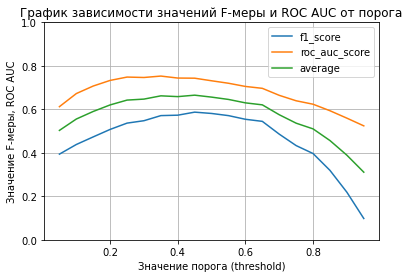

- Наибольшее значение F-меры = 0.59 при величине порога = 0.45
- Наибольшее значение ROC AUC = 0.75 при величине порога = 0.35
- Наибольшее взаимное значение ROC AUC = 0.74 и F-меры = 0.59 достигается при величине порога = 0.45

KNeighborsClassifier


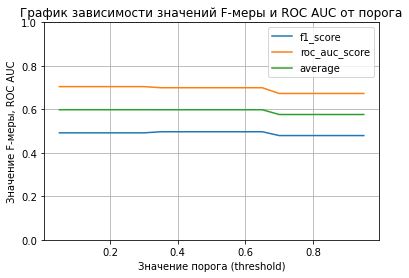

- Наибольшее значение F-меры = 0.50 при величине порога = 0.35
- Наибольшее значение ROC AUC = 0.70 при величине порога = 0.05
- Наибольшее взаимное значение ROC AUC = 0.70 и F-меры = 0.49 достигается при величине порога = 0.05

LogisticRegression


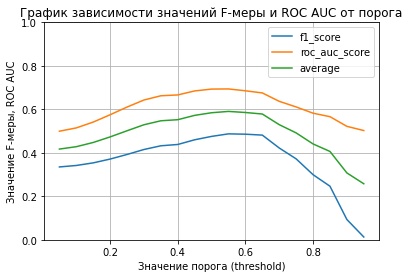

- Наибольшее значение F-меры = 0.49 при величине порога = 0.55
- Наибольшее значение ROC AUC = 0.69 при величине порога = 0.55
- Наибольшее взаимное значение ROC AUC = 0.69 и F-меры = 0.49 достигается при величине порога = 0.55



In [981]:
plot_f1_thresh(f1_data)

### 3.3 Метод downsampling<a id='step_3.3'></a>

Уменьшим количество объектов отрицательного класса, тем самым уравняв веса классов. Воспользуемся функцией sampling написанной ранее:

In [982]:
features_downsampled, target_downsampled = sampling(features_train, target_train, how='down')

Проверим размерность выборок:

In [983]:
print(features_downsampled.shape)
print(target_downsampled.shape)

(2752, 11)
(2752,)


### 3.4 Поиск наилучшей модели на обучении downsampled выборки<a id='step_3.4'></a>

Отлично. Теперь обучим модели на наших выборках и оценим максимальный f1_score!

In [984]:
best_model_params_ds, f1_data_ds = fit_models(features_downsampled, 
                                        target_downsampled, 
                                        features_valid, 
                                        target_valid, 
                                        params_lst)

Смотрим подобранные параметры:

In [985]:
best_model_params_ds

{'RandomForestClassifier': {'n_estimators': 21,
  'min_samples_split': 14,
  'min_samples_leaf': 5,
  'max_depth': 13},
 'KNeighborsClassifier': {'n_neighbors': 5,
  'leaf_size': 20,
  'algorithm': 'brute'},
 'LogisticRegression': {'penalty': 'l2',
  'max_iter': 130,
  'class_weight': 'None'}}

Строим график зависимости F-меры и ROC AUC от порога:

RandomForestClassifier


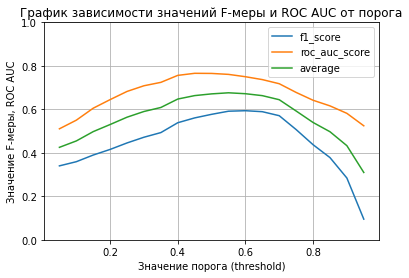

- Наибольшее значение F-меры = 0.59 при величине порога = 0.60
- Наибольшее значение ROC AUC = 0.77 при величине порога = 0.45
- Наибольшее взаимное значение ROC AUC = 0.76 и F-меры = 0.59 достигается при величине порога = 0.55

KNeighborsClassifier


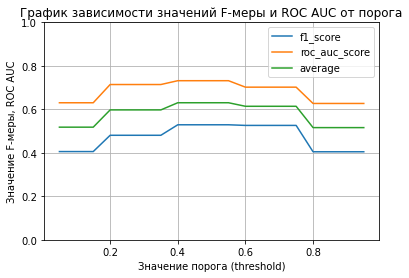

- Наибольшее значение F-меры = 0.53 при величине порога = 0.40
- Наибольшее значение ROC AUC = 0.73 при величине порога = 0.40
- Наибольшее взаимное значение ROC AUC = 0.73 и F-меры = 0.53 достигается при величине порога = 0.40

LogisticRegression


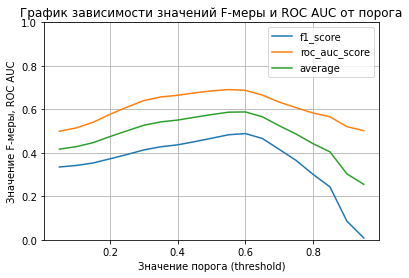

- Наибольшее значение F-меры = 0.49 при величине порога = 0.60
- Наибольшее значение ROC AUC = 0.69 при величине порога = 0.55
- Наибольшее взаимное значение ROC AUC = 0.69 и F-меры = 0.49 достигается при величине порога = 0.60



In [986]:
plot_f1_thresh(f1_data_ds)

### Вывод:

Судя по проведенным экспрериментам - моделям чуть лучше удается выявлять законометрности на выборках меньшего размера (downsampled выборках).

Наиболее высокое значение F-меры демонстрирует модель RandomForest обученная на downsampled выборке. 

На данный момент, лучшие результаты, которых добилась модель это:

- Наибольшее значение F-меры = 0.59 при величине порога = 0.55
- Наибольшее значение ROC AUC = 0.76 при величине порога = 0.45
- Наибольшее взаимное значение ROC AUC = 0.76 и F-меры = 0.59 достигается при величине порога = 0.55

Финально продолжим улучшать модель RandomForest показавшую наиболее высокие результы.

# 4. Тестирование модели<a id='step_4'></a>

Попробуем увеличить f1_score модели с наилучшим результатом. Для этого, переберем фичи и оставим только те, которые помогают модели лучше видеть закономерности.

Сохраним имена колонок - фичей в отдельной переменной

In [987]:
feature_names = features_downsampled.columns

Далее, запустим цикл, где будем отбирать самые полезные фичи. В этом нам поможет модель RFE. В цикле, укажем необходимое количество фичей, которое нужно оставить. Результат сохраним в список

In [988]:
lr = LinearRegression()

features_lst = []

for i in range(len(feature_names)-6, len(feature_names)):

    rfe = RFE(lr, n_features_to_select=i) 
    selector = rfe.fit(features_downsampled, target_downsampled)
    
    selected_features = np.array(feature_names)[selector.support_]
    new_cols = [i for i in selected_features]
    
    features_lst.append(new_cols)

Теперь, снова циклом будем из полученного списка брать список отобранных фичей, на его основе обучать модель, и смотреть полученную оценку f1_score. Так мы найдем оптимальные параметры для нашей задачи.

In [989]:
for col_set in features_lst:
    test_features = features_downsampled[col_set]
    valid_features = features_valid[col_set]
    
    model = RandomForestClassifier(random_state=42)
    clf = RandomizedSearchCV(model, params, random_state=42, scoring='f1')
    
    clf.fit(test_features, target_downsampled)
    
    best_model = clf.best_estimator_
    
    y_predict = best_model.predict(valid_features)
    
    print(len(col_set), f1_score(target_valid, y_predict))
    

5 0.5129032258064516
6 0.5108433734939759
7 0.5178713264495631
8 0.5141065830721004
9 0.5796064400715564
10 0.5746724890829694


Таким ообразом, максимальное значение f-меры достигается при обучении на 9 фичах. Их и оставляем. Финально, подберем оптимальное значение порога:

In [990]:
test_features = features_downsampled[features_lst[-2]]
valid_features = features_valid[features_lst[-2]]

In [991]:
best_model_params_ds, f1_data_ds = fit_models(test_features, 
                                        target_downsampled, 
                                        valid_features, 
                                        target_valid, 
                                        params_lst)

RandomForestClassifier


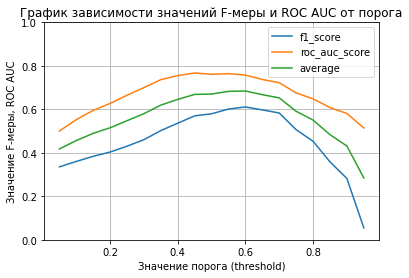

- Наибольшее значение F-меры = 0.611 при величине порога = 0.60
- Наибольшее значение ROC AUC = 0.767 при величине порога = 0.45
- Наибольшее взаимное значение ROC AUC = 0.757 и F-меры = 0.611 достигается при величине порога = 0.60

KNeighborsClassifier


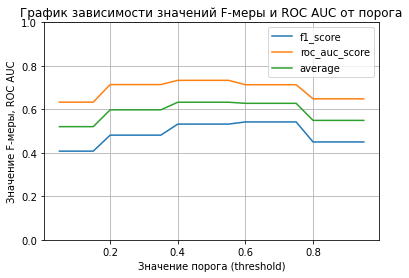

- Наибольшее значение F-меры = 0.542 при величине порога = 0.60
- Наибольшее значение ROC AUC = 0.733 при величине порога = 0.40
- Наибольшее взаимное значение ROC AUC = 0.733 и F-меры = 0.532 достигается при величине порога = 0.40

LogisticRegression


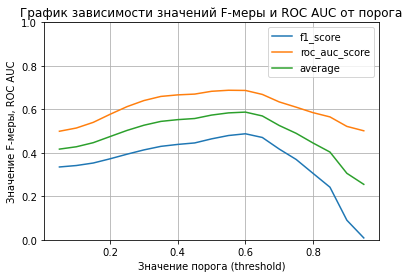

- Наибольшее значение F-меры = 0.488 при величине порога = 0.60
- Наибольшее значение ROC AUC = 0.688 при величине порога = 0.55
- Наибольшее взаимное значение ROC AUC = 0.687 и F-меры = 0.488 достигается при величине порога = 0.60



In [998]:
plot_f1_thresh(f1_data_ds)

### Вывод:

Лучшие результаты которых удалось достичь в ходе обучения модели:

- Наибольшее значение F-меры = 0.611 при величине порога = 0.60
- Наибольшее значение ROC AUC = 0.767 при величине порога = 0.45
- Наибольшее взаимное значение ROC AUC = 0.757 и F-меры = 0.611 достигается при величине порога = 0.60

## Общий вывод:<a id='step_5'></a>

По результатм проведенного исследования выявлено:

- Все рассмотренные модели хуже обучаются на выборках с дисбалансом классов.
- Чуть более высоких значений F-меры удалось добиться на downsampled выборках. Возможно, это не закономерность, а только частный случай.
- Более высокие показатели F-меры демонстрируют модели RandomForest. 
- Более точных результатов прогноза удается добиться с помощью поиска оптимального порога классификации.
- Большое количество признаков - не всегда хорошо. Убрав из анализа наименее информативные признаки удалось увеличить значение F-меры на 0.2 пункта.

Дополнительно, на задворках проекта, аналогичным образом были обучены модели на выборках с учетом выбросов. Объекты с аномальными объектами были отброшены. Результаты оказались даже хуже, чем у моделей обученных на выборках без учета дисбаланса. В силу этого, данные результаты в проекте не представлены.

# Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: задача исследована
    - [x]  Исследован баланс классов
    - [x]  Изучены модели без учёта дисбаланса
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 3: учтён дисбаланс
    - [x]  Применено несколько способов борьбы с дисбалансом
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 4: проведено тестирование
- [x]  Удалось достичь *F1*-меры не менее 0.59
- [x]  Исследована метрика *AUC-ROC*